<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Trabajo Práctico "Aprendizaje por Refuerzos" - Diplomatura en Ciencia de Datos

#### Integrante: Perez Herrera Pamela. 
#### Actividades (media materia):
1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".
2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.
3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de α, ϵ y γ.

### Funciones Iniciales -realizadas por los profes- para gráficos, ejecución de los modelos y definición de la política de explocación epsilon-greedy.



In [ ]:
#Funciones para gráficos.
import itertools
import numpy as np
from typing import Callable, Tuple
import gymnasium as gym
import matplotlib.pyplot as plt


# @title Código básico importacion y utilerías (no modificar)
def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

In [ ]:
#Funcion epsilon-greedy
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

## Modelo de aprendizaje SARSA. (Actividad 01)

In [ ]:
def learn_SARSA(
        state: int, # COMPLETAR tipo de cada parámetro
        action: int,
        reward: float,
        next_state: int,
        next_action: int,
        hyperparameters: dict,
        q: dict,
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: Representa el estado actual del agente.
        action: Reprensenta la acción que tomó en el estado actual.
        reward: Representa la recompensa obtenida luego de ejecutar la acción.
        next_state: Representa el siguiente estado al que llegó luego de la acción.
        next_action: Representa la próxima acción a ejecutar.
        hyperparameters: Son los hiperparámetros del agente ("alpha","gamma","epsilon","tau")
        q: Representa el diccionario de valores Q (estado-acción)
    """

    # Traemos los hiperparámetros del diccionario.
    alpha = hyperparameters['alpha']
    gamma = hyperparameters['gamma']

    # Valor Q actual (para el par estado-acción actual)
    q_actual = q.get((state, action), 0.0)

    # Valor Q para el par estado-acción siguiente
    q_siguiente = q.get((next_state, next_action), 0.0)

    # Calculamos la actualización SARSA
    nuevo_q = q_actual + alpha * (reward + gamma * q_siguiente - q_actual)

    # Actualizamos el diccionario de valores Q
    q[(state, action)] = nuevo_q
pass

## Modelo de aprendizaje Q-Learning. (Actividad 02)

In [92]:
def learn_Q_learning(
        state: int,
        action: int,
        reward: int,
        next_state: int,
        next_action: int,
        hyperparameters: dict,
        q: dict,
) -> None:

    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args:
        state: Representa el estado actual del agente.
        action: Reprensenta la acción que tomó en el estado actual.
        reward: Representa la recompensa obtenida luego de ejecutar la acción.
        next_state: Representa el siguiente estado al que llegó luego de la acción.
        next_action: Representa la próxima acción a ejecutar. No se usa en Q-Learning.
        hyperparameters: Son los hiperparámetros del agente ("alpha","gamma","epsilon","tau")
        q: Representa el diccionario de valores Q (estado-acción)
    
    """
    # Traemos los hiperparametros.
    alpha = hyperparameters.get("alpha")  # Tasa de aprendizaje
    gamma = hyperparameters.get("gamma")  # Factor de descuento

    # Calculamos el valor Q para el estado-acción actual
    q_actual = q.get((state, action), 0.0)

    # Calculamos el q maximo entre los estados-acciones futuros.
    q_siguientes = [q.get((next_state, a), 0.0) for a in actions]
    max_q = max(q_siguientes)

    # Calculamos la actualización Q-Learning
    nuevo_q = q_actual + alpha * (reward + gamma * max_q - q_actual)

    # Actualizar el valor Q en el diccionario q
    q[(state, action)] = nuevo_q

    pass

## Método para ejecutar ambos modelos.

In [85]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

## Ejecución del agente para función SARSA.

In [229]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.1,
    "gamma": 1,
    "epsilon": 0,
    "tau": 25,
}

# se puede cambiar por learn_Q_learning, una vez que se implemente
#learning_function = learn_SARSA
learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)


avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

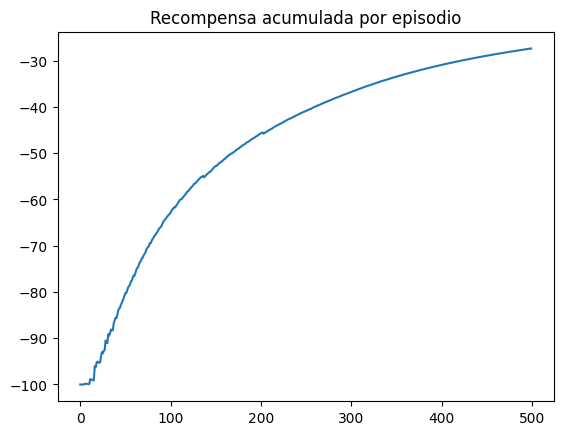

In [230]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

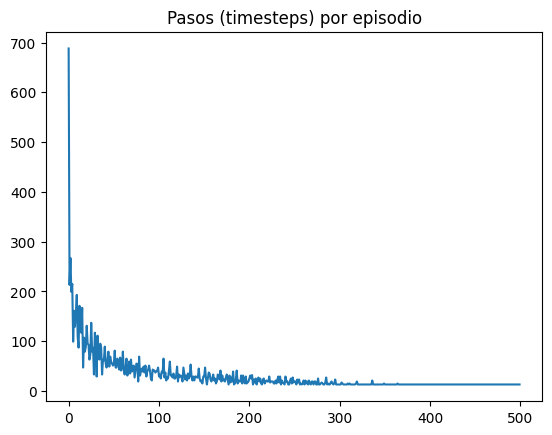

In [231]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

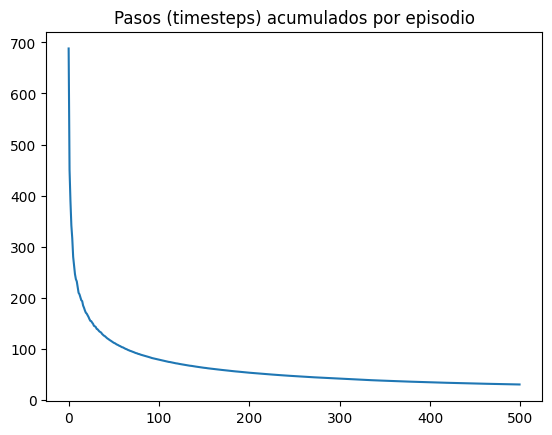

In [232]:
plot_steps_per_episode_smooth(timesteps_ep)

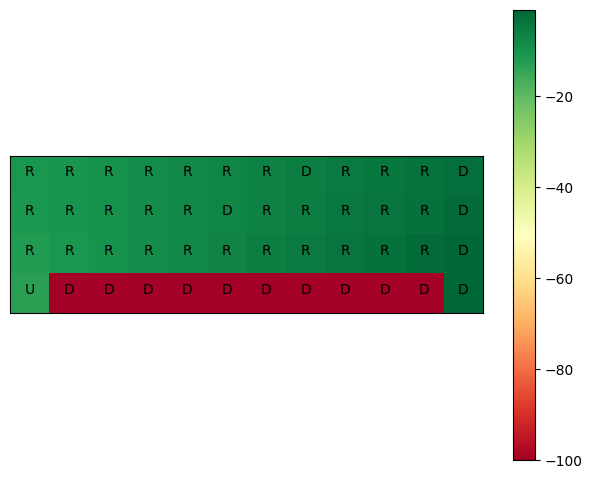


 Matriz de mejor acción-valor (en números): 

 [[ -10.88737457  -10.40139044   -9.75057053   -9.03420008   -8.28860733
    -7.51312787   -6.74053672   -5.94305212   -5.14355126   -4.3659765
    -3.58641367   -2.86286949]
 [ -11.30132131  -10.61490733   -9.84927599   -9.04494536   -8.21941783
    -7.3733394    -6.52279302   -5.64700522   -4.76609693   -3.86909806
    -2.94933119   -1.9981377 ]
 [ -11.99999995  -10.99999999  -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -12.99999976 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [233]:
draw_value_matrix(q)

In [234]:
env.close()

## Ejecución del agente para funcion Q-Learning.

In [236]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.1,
    "gamma": 1,
    "epsilon": 0,
    "tau": 25,
}

# se puede cambiar por learn_Q_learning, una vez que se implemente
#learning_function = learn_SARSA
learning_function = learn_Q_learning
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)


avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

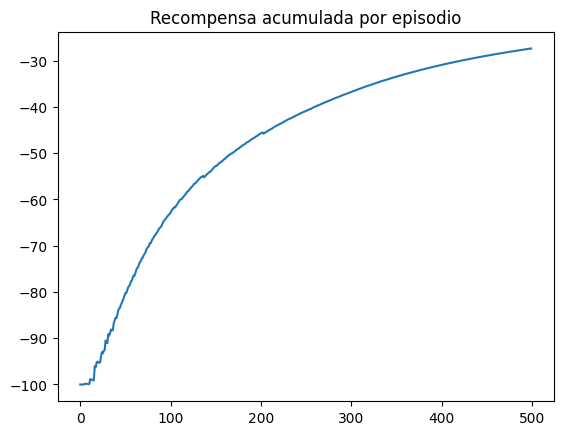

In [237]:
plot_reward_per_episode(reward_ep)

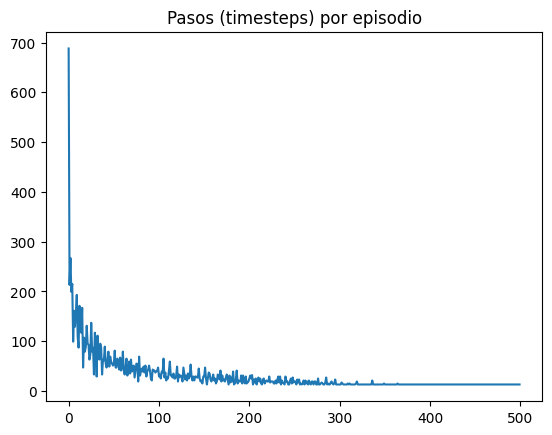

In [238]:
plot_steps_per_episode(timesteps_ep)

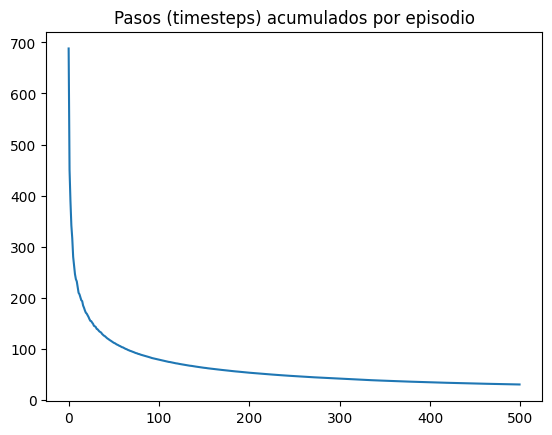

In [239]:
plot_steps_per_episode_smooth(timesteps_ep)

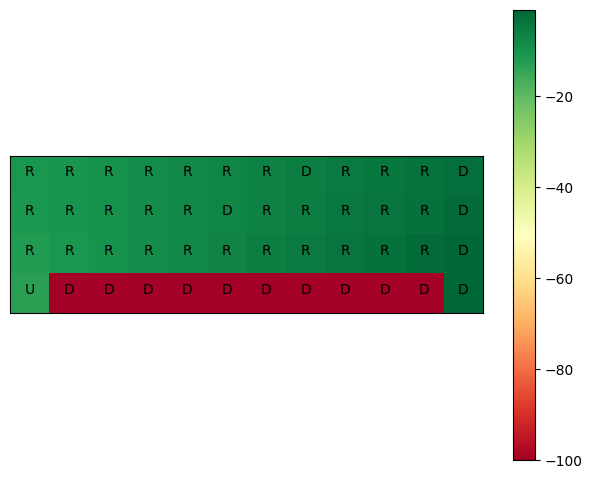


 Matriz de mejor acción-valor (en números): 

 [[ -10.88737457  -10.40139044   -9.75057053   -9.03420008   -8.28860733
    -7.51312787   -6.74053672   -5.94305212   -5.14355126   -4.3659765
    -3.58641367   -2.86286949]
 [ -11.30132131  -10.61490733   -9.84927599   -9.04494536   -8.21941783
    -7.3733394    -6.52279302   -5.64700522   -4.76609693   -3.86909806
    -2.94933119   -1.9981377 ]
 [ -11.99999995  -10.99999999  -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -12.99999976 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [240]:
draw_value_matrix(q)

In [222]:
env.close()

## Comparaciones y resultados.

#### Actividad 3: Probar los modelos con diferentes hyper-paramétros.
Hyper-parámetros:

Alpha es la taza de aprendizaje, valores altos hace que Q cambie más rápido en función de nuevas recompensas. Es útil cuando el entorno es muy dinámico. 


Gamma es el factor de descuento y representa cuánto peso se le da a recompensas futuras en comparación con recompensas inmediatas. Si el valor es alto se prioriza recompenzas a largo plazo.


Epsilon controla el equilibro entre exploración de nuevas acciones vs explotación de acciones conocidas que han dado buenos resultados.

### Imagen A:
En la imagen A utilicé una taza de aprendizaje alta, una visión "largo-plazista" y muy poca exploración. Si bien para ambos casos la recompensa acumulada creció y se fue estabilizando en un valor, es muy notorio que estos hyperparámetros no favorecen al algoritmo SARSA el cual no pudo estabilizar la cantidad de pasos por episodio en un valor bajo ni tuvo una matriz Q muy definida. Q-Learning por el contrario se pudo adaptar bien a estos hyperparametros aunque le costó más estabilizar los valores de la recompenza acumulada en cada episodio.

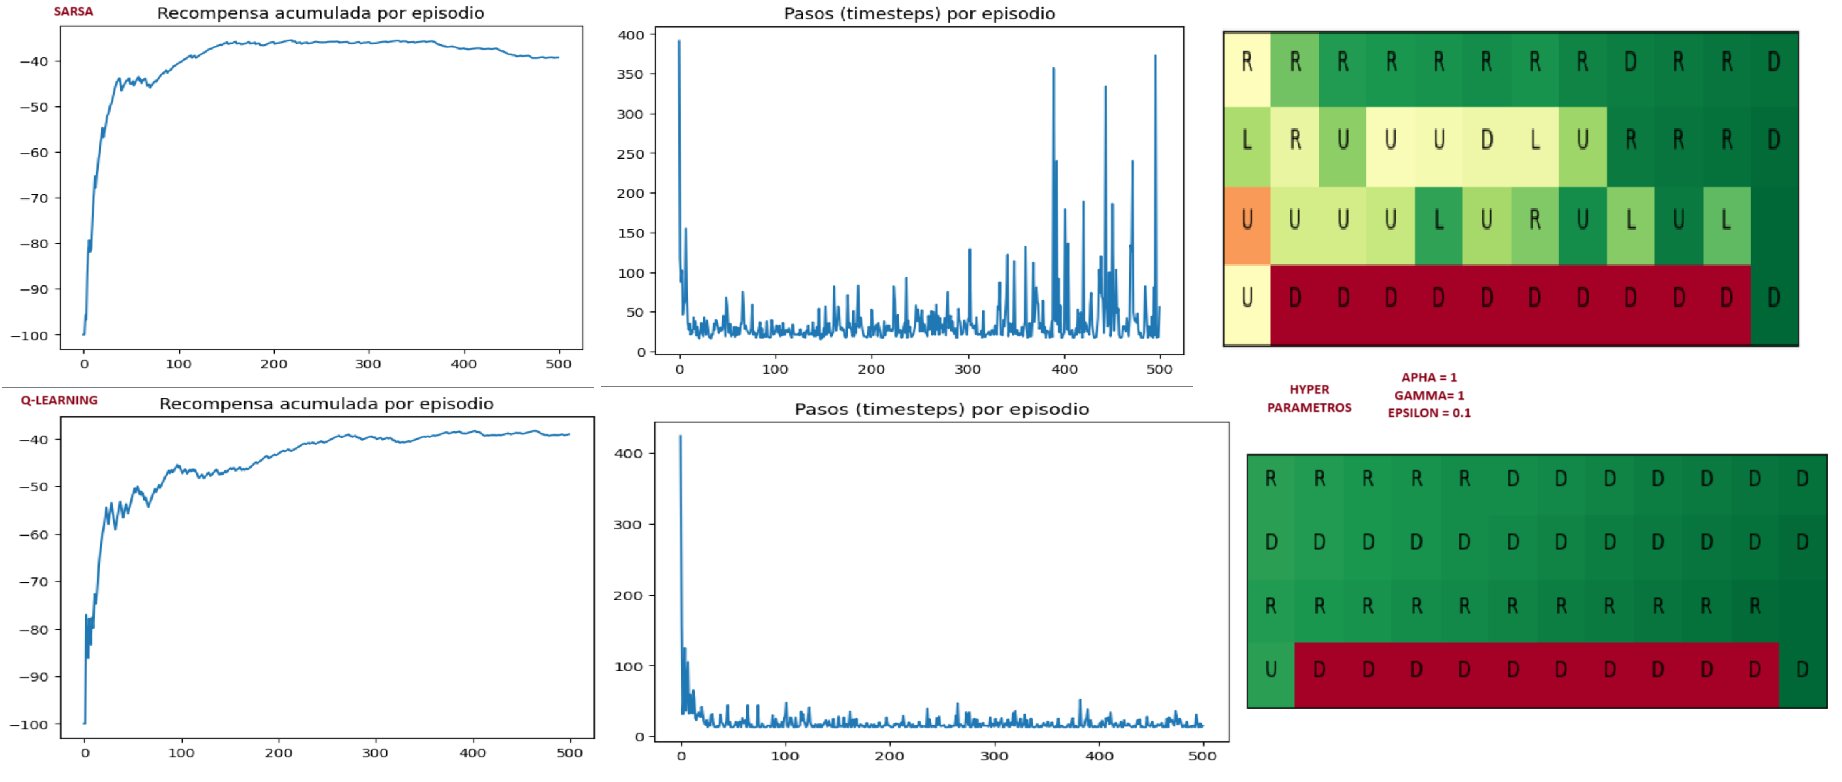

### Imagen B: 

En la imagen B utilicé una taza de aprendizaje más baja, una visión "largo-plazista" y una exploración muy baja. Al hacer esto ambos modelos tuvieron curvas de recompenzas acumuladas con valores mucho más estables y adicionalmente SARSA demostró mejor rendimiento al conseguir luego de los 200 episodios (aprox) tener cantidad de pasos menos elevados en cada episodio. La matriz Q que en los hyper-parametros anteriores SARSA no había diferenciado del todo las mejores acciones para el problema, con un alpha más bajo se corrigió y se ve claramente como únicas acciones negativas las del "acantilado" aunque de todas formas no termina de identificar el mejor valor ya que en varios casos elige la acción upper cuando está en el borde del "acantilado" a diferencia de Q-Learning que aprendió que es ir por el borde (RIGHT) hasta la punta y bajar.

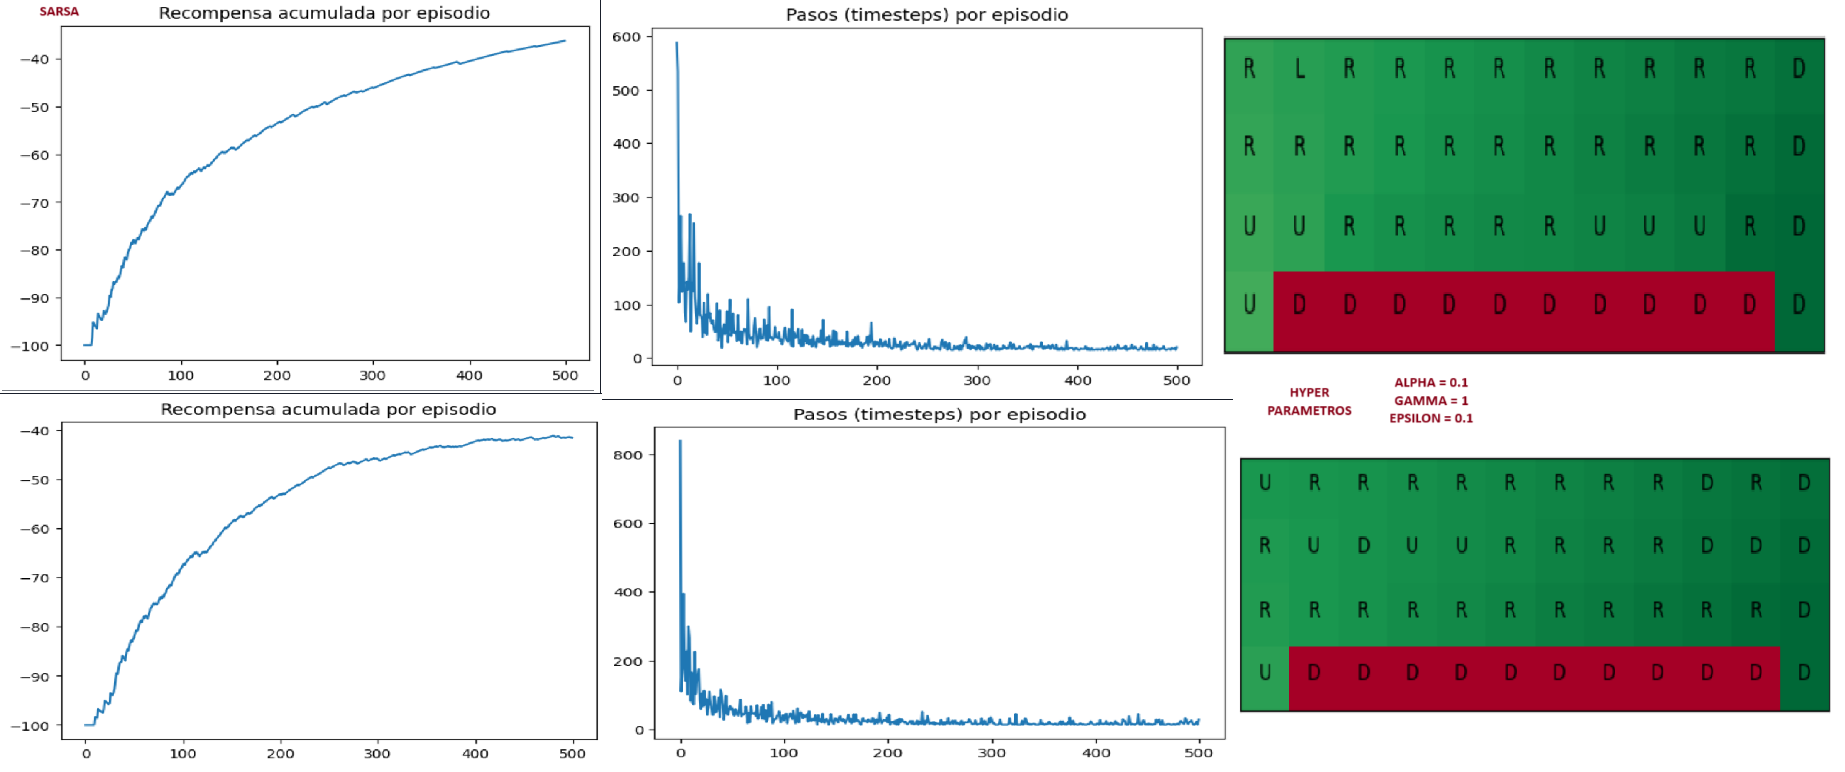

## Imagen C:

Si bien en clases vimos lo positivo que era "dejar cierto porcentaje de exploración", después de intentar varios hyper-parametros me encontré que el que me devolvía tanto valores estables en las curvas de recompensas acumuladas como de cantidad de pasos por episodios y que finalmente me devolvía ambas tablas Q con el mejor camino señalado era ejecutándolo con el valor epsilon en 0. Estimo que esto se debe a que es un problema muy simple, con un agente que dispone de pocas acciones, pocos estados y un entorno estático por lo cual elegir aumentar el valor de exploración no tenía mucho sentido y hacía que hubiese más altibajos. De todas formas si tuviera que elegir, para este problema, uno de los dos iría por Q-Learning que incluso con los peores parámetros hizo un mejor trabajo en encontrar el mejor camino para resolver el problema.

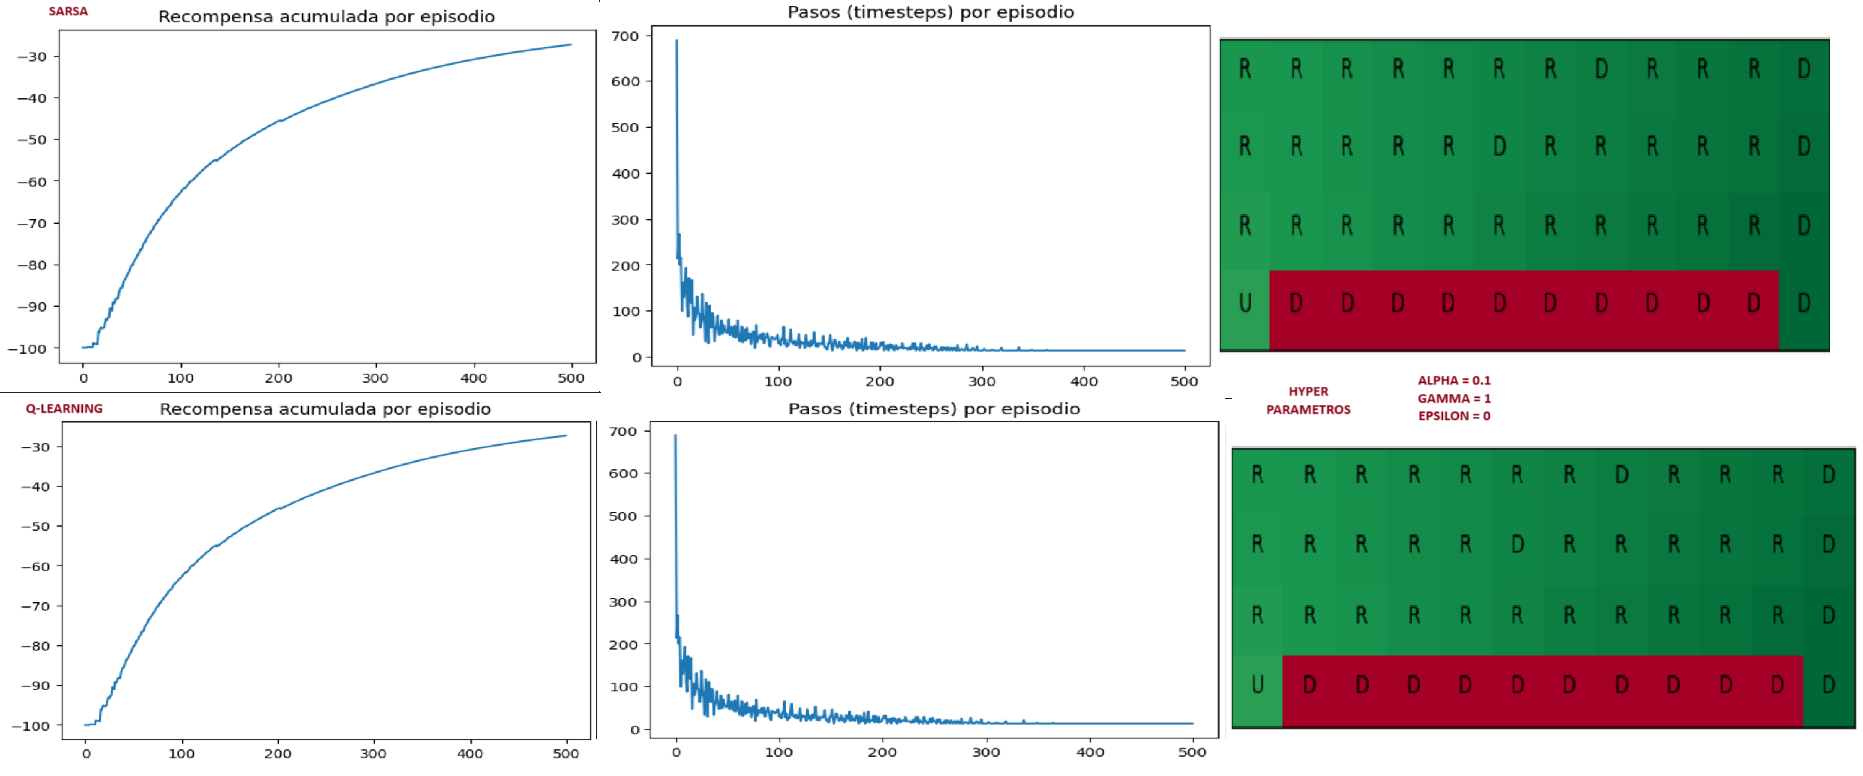

FIN